# CS189 HW6
Timothy Quang Nguyen

timotqn2@uci.edu

## Environment Setup

In [1]:
# Task: Predict the Baseline histological staging (multi-class classification)

import numpy as np # for data organization
import pandas as pd # for data organization

import sklearn as sk # for machine learning
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score # For Evaluation
from sklearn.preprocessing import MinMaxScaler, StandardScaler # To Scale Features
from sklearn.preprocessing import OneHotEncoder # To Encode Non-Numeric Columns
from sklearn.model_selection import GridSearchCV, train_test_split # For Hyper Parameter Tuning and Data Splitting
from skopt import BayesSearchCV # For Smart Hyper Parameter Tuning

from sklearn.linear_model import LogisticRegression # For Logistic Regression
from sklearn.ensemble import RandomForestClassifier # For Random Forest Classifier
from sklearn.svm import SVC # For Support Vector Classifier
from xgboost import XGBClassifier # For XGB Classifier
from sklearn.neighbors import KNeighborsClassifier # For KNN Classifier
from sklearn.neural_network import MLPClassifier # For MLP Classifier
from sklearn.tree import export_text
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting

In [2]:
pd.set_option('display.max_columns', None) # For better visualization of data

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
hepatitis_c_virus_hcv_for_egyptian_patients = fetch_ucirepo(id=503) 
  
# data (as pandas dataframes) 
X = hepatitis_c_virus_hcv_for_egyptian_patients.data.features 
y = hepatitis_c_virus_hcv_for_egyptian_patients.data.targets 
  
# metadata 
print(hepatitis_c_virus_hcv_for_egyptian_patients.metadata) 
  
# variable information 
print(hepatitis_c_virus_hcv_for_egyptian_patients.variables) 

{'uci_id': 503, 'name': 'Hepatitis C Virus (HCV) for Egyptian patients', 'repository_url': 'https://archive.ics.uci.edu/dataset/503/hepatitis+c+virus+hcv+for+egyptian+patients', 'data_url': 'https://archive.ics.uci.edu/static/public/503/data.csv', 'abstract': 'Egyptian patients who underwent treatment dosages for HCV about 18 months. Discretization should be applied based on expert recommendations; there is an attached file shows how.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1385, 'num_features': 28, 'feature_types': ['Real'], 'demographics': ['Age', 'Gender'], 'target_col': ['Baselinehistological staging'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2017, 'last_updated': 'Tue Apr 09 2024', 'dataset_doi': '10.24432/C5989V', 'creators': ['Sanaa Kamal', 'Mohamed ElEleimy', 'Doaa Hegazy', 'Mahmoud Nasr'], 'intro_paper': {'ID': 232, 'type': 'NATIVE', 'ti

## Function Declaration

In [30]:
# Used to produce confusion matrices and accuracy metrics for models
def confusion_matrix_and_metrics(y_te, y_pred, label_nums, label_names):
    
    # Used to produce a pretty Confusion Matrix
    cm = confusion_matrix(y_te, y_pred, labels=label_nums)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Used to produce metric data, precision, recall, F1 score, accuracy

    print("Precision of the MLP :\t" + str(precision_score(y_te, y_pred, average="macro")))
    print("Recall of the MLP    :\t" + str(recall_score(y_te, y_pred, average="macro")))
    print("F1 Score of the Model :\t" + str(f1_score(y_te, y_pred, average="macro")))
    print("Accuracy Score of the Model :\t" + str(round(accuracy_score(y_te, y_pred) * 100, 2)) + "%")

In [4]:
def evaluate_model(y_true, y_pred, label_nums, label_names):
    """
    Comprehensive evaluation for classification models.
    
    Parameters:
        y_true: True labels
        y_pred: Predicted labels
        label_nums: Numeric form of labels
        label_names: Name of labels
    """
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=label_nums)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average="macro"),
        'Recall': recall_score(y_true, y_pred, average="macro"),
        'F1 Score': f1_score(y_true, y_pred, average="macro")
    }

    # Print formatted metrics
    print("METRICS")
    print("="*40)
    for name, value in metrics.items():
        print(f'{name:<25}: {value:0.4f}')
    print("="*40)

In [5]:
# To showcase general data properties
def print_general_data_properties(data):
    rows, cols = data.shape

    print("Number of rows: ", rows)
    print("Number of columns: ", cols)
    print()
    print("All Columns:\n", data.columns)
    print()
    print("Column Types:\n", data.dtypes)

## Data Exploration

In [6]:
data = pd.concat([X, y], axis = 1) # Combining both the x and y data for exploration

data

,Age,Gender,BMI,Fever,Nausea/Vomting,Headache,Diarrhea,Fatigue & generalized bone ache,Jaundice,Epigastric pain,WBC,RBC,HGB,Plat,AST 1,ALT 1,ALT4,ALT 12,ALT 24,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF,Baseline histological Grading,Baselinehistological staging
0,56,1,35,2,1,1,1,2,2,2,7425,4248807.0,14,112132.0,99,84,52.0,109,81,5,5,5,655330,634536,288194,5,5,13,2
1,46,1,29,1,2,2,1,2,2,1,12101,4429425.0,10,129367.0,91,123,95.0,75,113,57,123,44,40620,538635,637056,336804,31085,4,2
2,57,1,33,2,2,2,2,1,1,1,4178,4621191.0,12,151522.0,113,49,95.0,107,116,5,5,5,571148,661346,5,735945,558829,4,4
3,49,2,33,1,2,1,2,1,2,1,6490,4794631.0,10,146457.0,43,64,109.0,80,88,48,77,33,1041941,449939,585688,744463,582301,10,3
4,59,1,32,1,1,2,1,2,2,2,3661,4606375.0,11,187684.0,99,104,67.0,48,120,94,90,30,660410,738756,3731527,338946,242861,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380,44,1,29,1,2,2,2,1,1,1,7044,4957174.0,15,202520.0,122,59,78.0,106,127,63,44,45,387795,55938,5,5,5,15,4
1381,55,1,34,1,2,2,1,1,1,1,6207,4636951.0,10,115776.0,128,102,65.0,99,108,97,64,41,481378,152961,393339,73574,236273,10,2
1382,42,1,26,2,2,1,1,1,2,1,4913,4122038.0,14,128354.0,61,93,123.0,61,116,87,39,24,612664,572756,806109,343719,160457,6,2
1383,52,1,29,2,1,1,2,2,2,1,7257,4241990.0,10,205908.0,70,97,104.0,74,47,48,81,43,139872,76161,515730,2460,696074,15,3


In [7]:
print_general_data_properties(data)

Number of rows:  1385
Number of columns:  29

All Columns:
 Index(['Age ', 'Gender', 'BMI', 'Fever', 'Nausea/Vomting', 'Headache ',
       'Diarrhea ', 'Fatigue & generalized bone ache ', 'Jaundice ',
       'Epigastric pain ', 'WBC', 'RBC', 'HGB', 'Plat', 'AST 1', 'ALT 1',
       'ALT4', 'ALT 12', 'ALT 24', 'ALT 36', 'ALT 48', 'ALT after 24 w',
       'RNA Base', 'RNA 4', 'RNA 12', 'RNA EOT', 'RNA EF',
       'Baseline histological Grading', 'Baselinehistological staging'],
      dtype='object')

Column Types:
 Age                                   int64
Gender                                int64
BMI                                   int64
Fever                                 int64
Nausea/Vomting                        int64
Headache                              int64
Diarrhea                              int64
Fatigue & generalized bone ache       int64
Jaundice                              int64
Epigastric pain                       int64
WBC                                   int6

In [8]:
# Display any missing data

missing_data = pd.DataFrame(data.isnull().sum())
missing_data.columns = ['Number of Missing']
missing_data = missing_data[missing_data['Number of Missing'] != 0]
print(missing_data)

Empty DataFrame
Columns: [Number of Missing]
Index: []


<Axes: xlabel='Baselinehistological staging', ylabel='Count'>

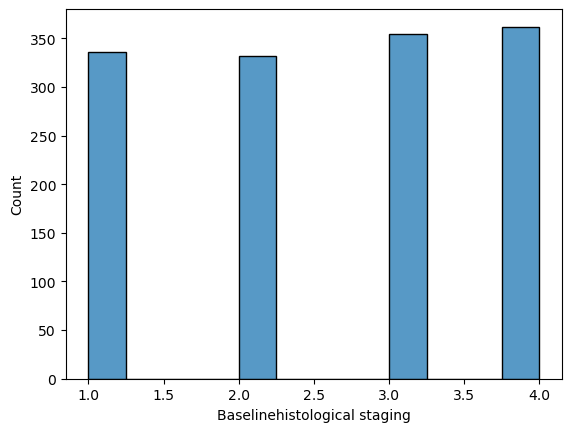

In [9]:
# Distribution of target data

sns.histplot(data['Baselinehistological staging'])

In [10]:
# Show general statistics of data
data.describe(include="all")

,Age,Gender,BMI,Fever,Nausea/Vomting,Headache,Diarrhea,Fatigue & generalized bone ache,Jaundice,Epigastric pain,WBC,RBC,HGB,Plat,AST 1,ALT 1,ALT4,ALT 12,ALT 24,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF,Baseline histological Grading,Baselinehistological staging
count,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1.385000e+03,1385.000000,1385.00000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1.385000e+03,1.385000e+03,1.385000e+03,1385.000000,1385.000000,1385.000000,1385.000000
mean,46.319134,1.489531,28.608664,1.515523,1.502527,1.496029,1.502527,1.498917,1.501083,1.503971,7533.386282,4.422130e+06,12.587726,158348.06065,82.774729,83.916245,83.405776,83.510469,83.709025,83.117690,83.629603,33.438267,5.909512e+05,6.008956e+05,2.887536e+05,287660.336462,291378.290975,9.761733,2.536462
std,8.781506,0.500071,4.076215,0.499939,0.500174,0.500165,0.500174,0.500179,0.500179,0.500165,2668.220333,3.463577e+05,1.713511,38794.78555,25.993242,25.922800,26.529730,26.064478,26.205994,26.399031,26.223955,7.073569,3.539354e+05,3.623151e+05,2.853507e+05,264559.525070,267700.691713,4.023896,1.121392
min,32.000000,1.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2991.000000,3.816422e+06,10.000000,93013.00000,39.000000,39.000000,39.000000,39.000000,39.000000,5.000000,5.000000,5.000000,1.100000e+01,5.000000e+00,5.000000e+00,5.000000,5.000000,3.000000,1.000000
25%,39.000000,1.000000,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5219.000000,4.121374e+06,11.000000,124479.00000,60.000000,62.000000,61.000000,60.000000,61.000000,61.000000,61.000000,28.000000,2.692530e+05,2.708930e+05,5.000000e+00,5.000000,5.000000,6.000000,2.000000
50%,46.000000,1.000000,29.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,7498.000000,4.438465e+06,13.000000,157916.00000,83.000000,83.000000,82.000000,84.000000,83.000000,84.000000,83.000000,34.000000,5.931030e+05,5.978690e+05,2.343590e+05,251376.000000,244049.000000,10.000000,3.000000
75%,54.000000,2.000000,32.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,9902.000000,4.721279e+06,14.000000,190314.00000,105.000000,106.000000,107.000000,106.000000,107.000000,106.000000,106.000000,40.000000,8.867910e+05,9.090930e+05,5.248190e+05,517806.000000,527864.000000,13.000000,4.000000
max,61.000000,2.000000,35.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,12101.000000,5.018451e+06,15.000000,226464.00000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,45.000000,1.201086e+06,1.201715e+06,3.731527e+06,808450.000000,810333.000000,16.000000,4.000000


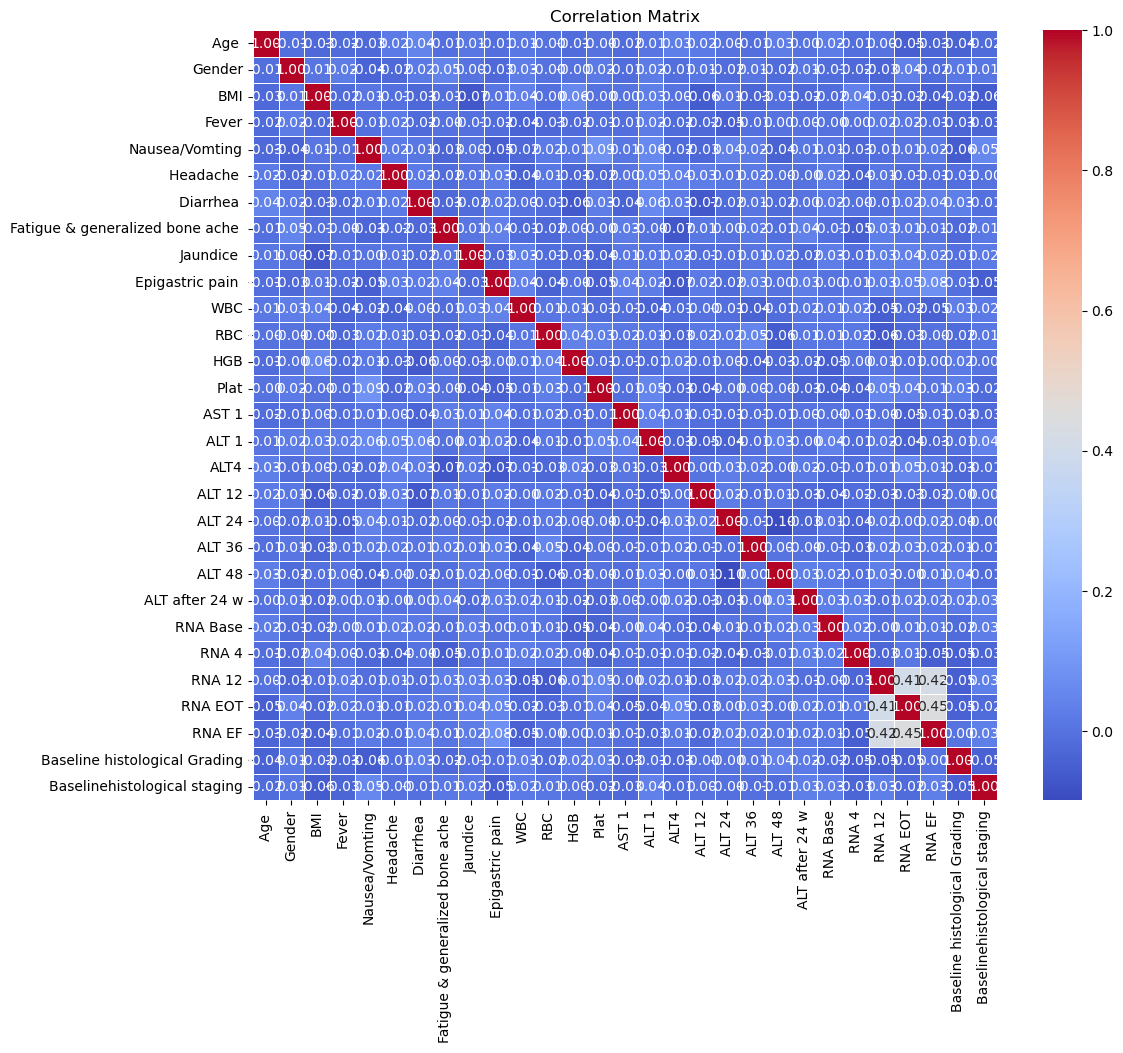

In [11]:
# Correlation heatmap for all columns
corr_matrix = data.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt="0.2f", linewidth=0.5)
plt.title("Correlation Matrix")
plt.show()

<Axes: xlabel='Baseline histological Grading', ylabel='Count'>

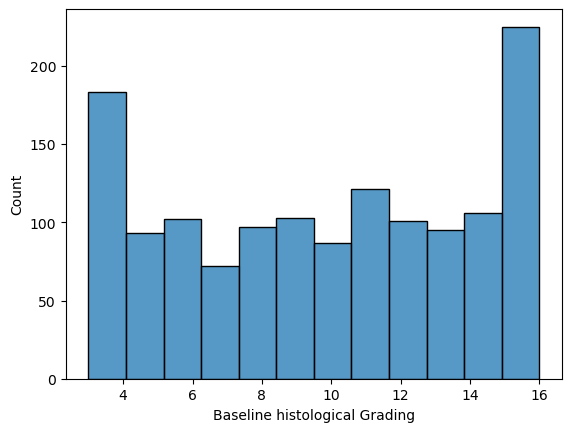

In [12]:
# Distribution of baseline histological grading data

sns.histplot(data['Baseline histological Grading'])

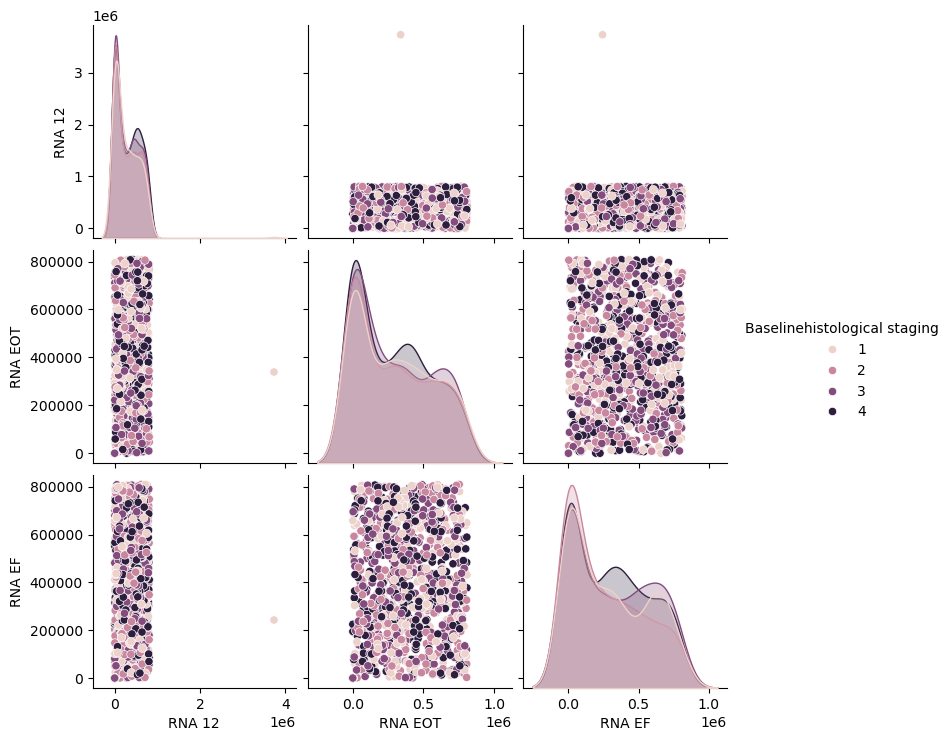

In [13]:
# Scatter plots of mildly related features

sns.pairplot(data[['RNA 12', 'RNA EOT', 'RNA EF', 'Baselinehistological staging']], hue='Baselinehistological staging')

## Data Preprocessing

### Split X and Y data

In [14]:
y_data = pd.DataFrame(data['Baselinehistological staging'])
x_data = data.drop('Baselinehistological staging', axis=1)

print(y_data)
print(x_data)

      Baselinehistological staging
0                                2
1                                2
2                                4
3                                3
4                                1
...                            ...
1380                             4
1381                             2
1382                             2
1383                             3
1384                             3

[1385 rows x 1 columns]
      Age   Gender  BMI  Fever  Nausea/Vomting  Headache   Diarrhea   \
0       56       1   35      2               1          1          1   
1       46       1   29      1               2          2          1   
2       57       1   33      2               2          2          2   
3       49       2   33      1               2          1          2   
4       59       1   32      1               1          2          1   
...    ...     ...  ...    ...             ...        ...        ...   
1380    44       1   29      1               2     

### One-Hot Encode Binary Columns

In [15]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
binary_columns = ['Fever', 
                  'Nausea/Vomting', 
                  'Headache ', 
                  'Diarrhea ', 
                  'Fatigue & generalized bone ache ', 
                  'Jaundice ', 
                  'Epigastric pain ', 
                  'Gender']

encoded_columns = encoder.fit_transform(x_data[binary_columns])
new_columns = pd.DataFrame(encoded_columns, columns=['F1', 'F2', 
                                                     'N1', 'N2', 
                                                     'H1', 'H2', 
                                                     'D1', 'D2', 
                                                     'FG1', 'FG2', 
                                                     'J1', 'J2', 
                                                     'E1', 'E2', 
                                                     'G1', 'G2'])

x_data = x_data.drop(binary_columns, axis=1)
x_data = pd.concat([x_data, new_columns], axis=1)
x_data

,Age,BMI,WBC,RBC,HGB,Plat,AST 1,ALT 1,ALT4,ALT 12,ALT 24,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF,Baseline histological Grading,F1,F2,N1,N2,H1,H2,D1,D2,FG1,FG2,J1,J2,E1,E2,G1,G2
0,56,35,7425,4248807.0,14,112132.0,99,84,52.0,109,81,5,5,5,655330,634536,288194,5,5,13,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1,46,29,12101,4429425.0,10,129367.0,91,123,95.0,75,113,57,123,44,40620,538635,637056,336804,31085,4,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2,57,33,4178,4621191.0,12,151522.0,113,49,95.0,107,116,5,5,5,571148,661346,5,735945,558829,4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,49,33,6490,4794631.0,10,146457.0,43,64,109.0,80,88,48,77,33,1041941,449939,585688,744463,582301,10,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,59,32,3661,4606375.0,11,187684.0,99,104,67.0,48,120,94,90,30,660410,738756,3731527,338946,242861,11,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380,44,29,7044,4957174.0,15,202520.0,122,59,78.0,106,127,63,44,45,387795,55938,5,5,5,15,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1381,55,34,6207,4636951.0,10,115776.0,128,102,65.0,99,108,97,64,41,481378,152961,393339,73574,236273,10,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1382,42,26,4913,4122038.0,14,128354.0,61,93,123.0,61,116,87,39,24,612664,572756,806109,343719,160457,6,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1383,52,29,7257,4241990.0,10,205908.0,70,97,104.0,74,47,48,81,43,139872,76161,515730,2460,696074,15,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


### Scale Data

In [16]:
scaler = MinMaxScaler()
x_data = pd.DataFrame(scaler.fit_transform(x_data), columns=x_data.columns)

x_data

,Age,BMI,WBC,RBC,HGB,Plat,AST 1,ALT 1,ALT4,ALT 12,ALT 24,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF,Baseline histological Grading,F1,F2,N1,N2,H1,H2,D1,D2,FG1,FG2,J1,J2,E1,E2,G1,G2
0,0.827586,1.000000,0.486718,0.359713,0.8,0.143266,0.674157,0.505618,0.146067,0.786517,0.471910,0.000000,0.000000,0.000,0.545610,0.528023,0.077231,0.000000,0.000000,0.769231,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.482759,0.538462,1.000000,0.509974,0.0,0.272415,0.584270,0.943820,0.629213,0.404494,0.831461,0.422764,0.959350,0.975,0.033811,0.448220,0.170721,0.416601,0.038355,0.076923,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.862069,0.846154,0.130296,0.669509,0.4,0.438431,0.831461,0.112360,0.629213,0.764045,0.865169,0.000000,0.000000,0.000,0.475522,0.550333,0.000000,0.910315,0.689627,0.076923,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.586207,0.846154,0.384083,0.813798,0.0,0.400477,0.044944,0.280899,0.786517,0.460674,0.550562,0.349593,0.585366,0.700,0.867498,0.374411,0.156956,0.920852,0.718593,0.538462,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,0.931034,0.769231,0.073546,0.657183,0.2,0.709406,0.674157,0.730337,0.314607,0.101124,0.910112,0.723577,0.691057,0.625,0.549840,0.614750,1.000000,0.419251,0.299701,0.615385,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380,0.413793,0.538462,0.444896,0.949022,1.0,0.820578,0.932584,0.224719,0.438202,0.752809,0.988764,0.471545,0.317073,1.000,0.322864,0.046545,0.000000,0.000000,0.000000,0.923077,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1381,0.793103,0.923077,0.353019,0.682620,0.0,0.170572,1.000000,0.707865,0.292135,0.674157,0.775281,0.747967,0.479675,0.900,0.400780,0.127282,0.105408,0.091001,0.291571,0.538462,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1382,0.344828,0.307692,0.210977,0.254250,0.8,0.264824,0.247191,0.606742,0.943820,0.247191,0.865169,0.666667,0.276423,0.475,0.510087,0.476613,0.216026,0.425154,0.198009,0.230769,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1383,0.689655,0.538462,0.468277,0.354041,0.0,0.845966,0.348315,0.651685,0.730337,0.393258,0.089888,0.349593,0.617886,0.950,0.116447,0.063373,0.138208,0.003037,0.858997,0.923077,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


### Split Train and Test Data

In [17]:
# Ratio 80% Training and 20% Testing
x_tr, x_te, y_tr, y_te = train_test_split(x_data, y_data, test_size=0.2, shuffle=True, stratify=y_data, random_state=22)

print(x_tr.shape)
print(x_te.shape)
print(y_tr.shape)
print(y_te.shape)

(1108, 36)
(277, 36)
(1108, 1)
(277, 1)


## Logistic Regression

### Logistic Regression Default

In [18]:
# Linear Regression Model
lr_model = LogisticRegression(random_state=22, max_iter=1000)
lr_model.fit(x_tr, y_tr.values.ravel())
lr_y_pred = lr_model.predict(x_te)

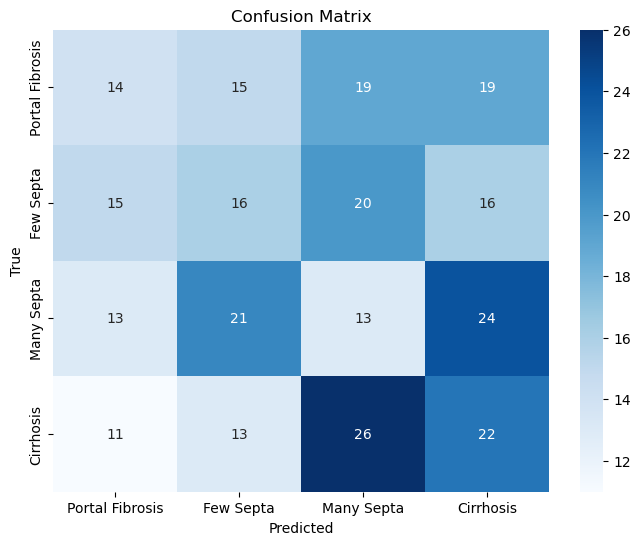

METRICS
Accuracy                 : 0.2347
Precision                : 0.2371
Recall                   : 0.2341
F1 Score                 : 0.2345


In [19]:
# Model Evaluation
evaluate_model(y_te, lr_y_pred, [1, 2, 3, 4], ["Portal Fibrosis", "Few Septa", "Many Septa", "Cirrhosis"])

## Random Forest

### Random Forest Default

In [20]:
# Random Forest Classifier Model
rf_model = RandomForestClassifier(random_state=22)
rf_model.fit(x_tr, y_tr.values.ravel())
rf_y_pred = rf_model.predict(x_te)

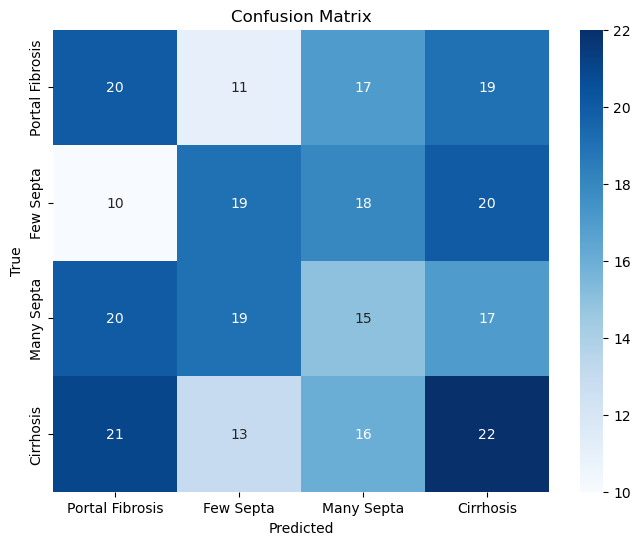

METRICS
Accuracy                 : 0.2744
Precision                : 0.2744
Recall                   : 0.2747
F1 Score                 : 0.2742


In [21]:
# Model Evaluation
evaluate_model(y_te, rf_y_pred, [1, 2, 3, 4], ["Portal Fibrosis", "Few Septa", "Many Septa", "Cirrhosis"])

### Random Forest Tuned

In [33]:
# Use Bayesian Optimization to find the best set of hyperparameters
rf_params = {"n_estimators": (10, 500), 
              "max_features": ["sqrt", "log2", 0.2, 0.5, 0.7, 1],
              "max_depth": [3, 5, 10, 15, 20, None], 
              "min_samples_leaf": (1, 15)}

rf_opt = BayesSearchCV(RandomForestClassifier(random_state=22), rf_params, verbose=3, n_iter=50)
rf_opt.fit(x_tr, y_tr.values.ravel())

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=None, max_features=0.5, min_samples_leaf=7, n_estimators=171;, score=0.275 total time=   1.1s
[CV 2/5] END max_depth=None, max_features=0.5, min_samples_leaf=7, n_estimators=171;, score=0.279 total time=   1.1s
[CV 3/5] END max_depth=None, max_features=0.5, min_samples_leaf=7, n_estimators=171;, score=0.288 total time=   1.0s
[CV 4/5] END max_depth=None, max_features=0.5, min_samples_leaf=7, n_estimators=171;, score=0.276 total time=   1.1s
[CV 5/5] END max_depth=None, max_features=0.5, min_samples_leaf=7, n_estimators=171;, score=0.271 total time=   1.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=5, max_features=log2, min_samples_leaf=13, n_estimators=453;, score=0.275 total time=   1.0s
[CV 2/5] END max_depth=5, max_features=log2, min_samples_leaf=13, n_estimators=453;, score=0.234 total time=   1.1s
[CV 3/5] END max_depth=5, max_features=log2, min_samples_leaf=13,

BayesSearchCV(estimator=RandomForestClassifier(random_state=22),
              search_spaces={'max_depth': [3, 5, 10, 15, 20, None],
                             'max_features': ['sqrt', 'log2', 0.2, 0.5, 0.7, 1],
                             'min_samples_leaf': (1, 15),
                             'n_estimators': (10, 500)},
              verbose=3)

In [34]:
# Random Forest Classifier Model
print(rf_opt.best_estimator_)
rf_model_tuned = rf_opt.best_estimator_
rf_tuned_y_pred = rf_model_tuned.predict(x_te)

RandomForestClassifier(max_depth=20, max_features=0.5, n_estimators=282,
                       random_state=22)


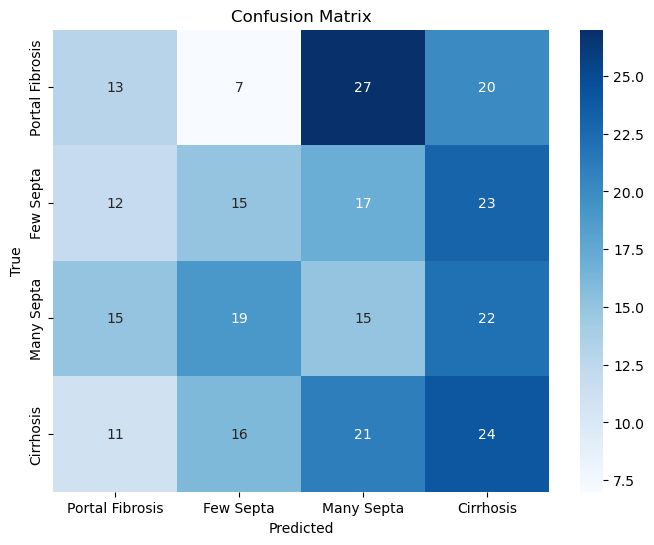

METRICS
Accuracy                 : 0.2419
Precision                : 0.2438
Recall                   : 0.2406
F1 Score                 : 0.2398


In [35]:
# Model Evaluation
evaluate_model(y_te, rf_tuned_y_pred, [1, 2, 3, 4], ["Portal Fibrosis", "Few Septa", "Many Septa", "Cirrhosis"])

## Support Vector Classifier (SVC)

### SVC Default

In [22]:
# SVC Model
svc_model = SVC(random_state=22)
svc_model.fit(x_tr, y_tr.values.ravel())
svc_y_pred = svc_model.predict(x_te)

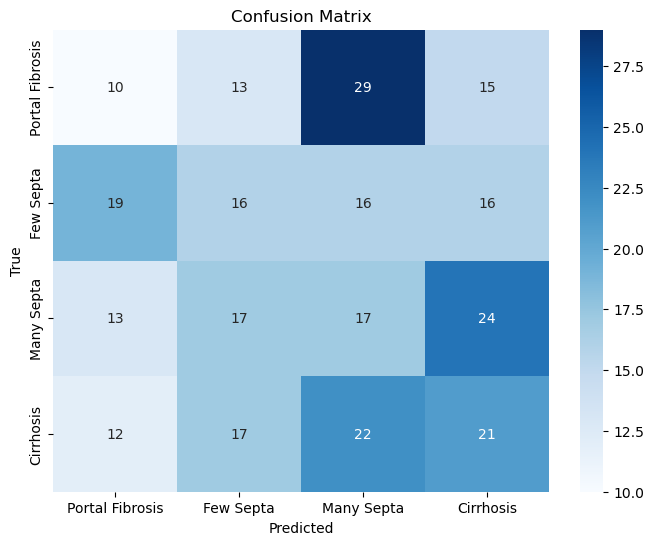

METRICS
Accuracy                 : 0.2310
Precision                : 0.2295
Recall                   : 0.2298
F1 Score                 : 0.2286


In [23]:
# Model Evaluation
evaluate_model(y_te, svc_y_pred, [1, 2, 3, 4], ["Portal Fibrosis", "Few Septa", "Many Septa", "Cirrhosis"])

### SVC Tuned

In [37]:
# Use Bayesian Optimization to find the best set of hyperparameters
svc_params = {"kernel": ["linear", "poly", "rbf", "sigmoid"], 
            "degree": (0, 10), 
            "gamma": ["scale", "auto", 1, 0.1, 0.001, 0.0001], 
            "C": (0.001, 1000)}

svc_opt = BayesSearchCV(SVC(random_state=22), svc_params, verbose=3, n_iter=50)
svc_opt.fit(x_tr, y_tr.values.ravel())

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END C=29.697231079214614, degree=10, gamma=0.0001, kernel=poly;, score=0.261 total time=   0.0s
[CV 2/5] END C=29.697231079214614, degree=10, gamma=0.0001, kernel=poly;, score=0.261 total time=   0.0s
[CV 3/5] END C=29.697231079214614, degree=10, gamma=0.0001, kernel=poly;, score=0.261 total time=   0.0s
[CV 4/5] END C=29.697231079214614, degree=10, gamma=0.0001, kernel=poly;, score=0.262 total time=   0.0s
[CV 5/5] END C=29.697231079214614, degree=10, gamma=0.0001, kernel=poly;, score=0.262 total time=   0.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END C=135.76905855188753, degree=9, gamma=auto, kernel=poly;, score=0.261 total time=   0.0s
[CV 2/5] END C=135.76905855188753, degree=9, gamma=auto, kernel=poly;, score=0.261 total time=   0.0s
[CV 3/5] END C=135.76905855188753, degree=9, gamma=auto, kernel=poly;, score=0.261 total time=   0.0s
[CV 4/5] END C=135.76905855188753, degree=9, gamma=

BayesSearchCV(estimator=SVC(random_state=22),
              search_spaces={'C': (0.001, 1000), 'degree': (0, 10),
                             'gamma': ['scale', 'auto', 1, 0.1, 0.001, 0.0001],
                             'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
              verbose=3)

In [38]:
# SVC Model
print(svc_opt.best_estimator_)
svc_model_tuned = svc_opt.best_estimator_
svc_tuned_y_pred = svc_model_tuned.predict(x_te)

SVC(C=11.213989475122206, degree=8, kernel='sigmoid', random_state=22)


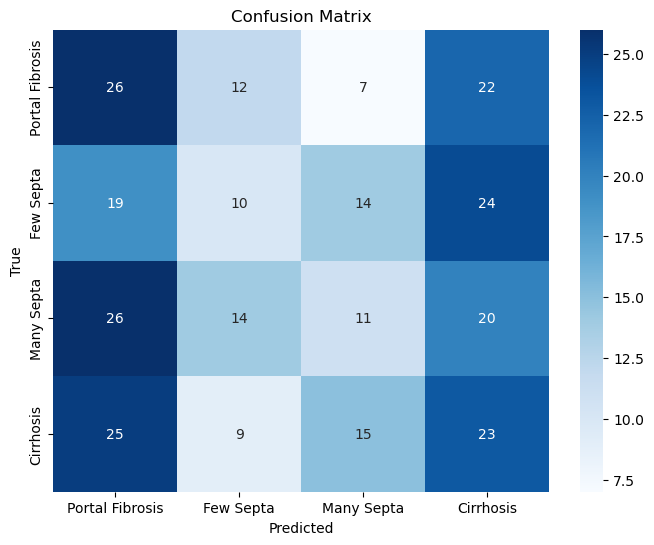

METRICS
Accuracy                 : 0.2527
Precision                : 0.2464
Recall                   : 0.2529
F1 Score                 : 0.2424


In [39]:
# Model Evaluation
evaluate_model(y_te, svc_tuned_y_pred, [1, 2, 3, 4], ["Portal Fibrosis", "Few Septa", "Many Septa", "Cirrhosis"])

## XGB Classifier

### XGB Default

In [24]:
# XGB Model
xgb_y_tr = y_tr - 1
xgb_y_te = y_te - 1

xgb_model = XGBClassifier(random_state=22)
xgb_model.fit(x_tr, xgb_y_tr.values.ravel())
xgb_y_pred = xgb_model.predict(x_te)

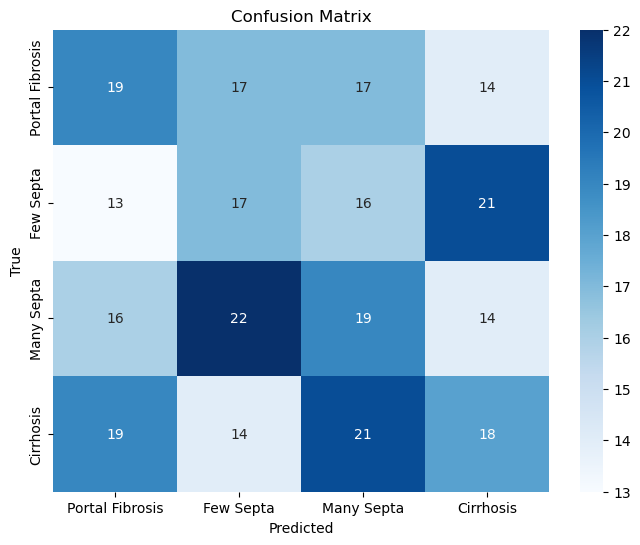

METRICS
Accuracy                 : 0.2635
Precision                : 0.2638
Recall                   : 0.2637
F1 Score                 : 0.2637


In [25]:
# Model Evaluation
evaluate_model(xgb_y_te, xgb_y_pred, [0, 1, 2, 3], ["Portal Fibrosis", "Few Septa", "Many Septa", "Cirrhosis"])

### XGB Tuned

In [40]:
# Use Bayesian Optimization to find the best set of hyperparameters
xgb_params = {"n_estimators": (10, 500), 
              "eta": (0.0001, 1),
              "max_depth": (1, 9), 
              "subsample": (0.1, 1), 
              "colsample_bytree": (0.1, 1)}

xgb_opt = BayesSearchCV(XGBClassifier(random_state=22), xgb_params, verbose=3, n_iter=50)
xgb_opt.fit(x_tr, xgb_y_tr.values.ravel())
xgb_opt.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bytree=0.7778746952419612, eta=0.35758155814055, max_depth=5, n_estimators=281, subsample=0.14453394838650543;, score=0.225 total time=   1.9s
[CV 2/5] END colsample_bytree=0.7778746952419612, eta=0.35758155814055, max_depth=5, n_estimators=281, subsample=0.14453394838650543;, score=0.225 total time=   2.0s
[CV 3/5] END colsample_bytree=0.7778746952419612, eta=0.35758155814055, max_depth=5, n_estimators=281, subsample=0.14453394838650543;, score=0.302 total time=   2.1s
[CV 4/5] END colsample_bytree=0.7778746952419612, eta=0.35758155814055, max_depth=5, n_estimators=281, subsample=0.14453394838650543;, score=0.244 total time=   2.0s
[CV 5/5] END colsample_bytree=0.7778746952419612, eta=0.35758155814055, max_depth=5, n_estimators=281, subsample=0.14453394838650543;, score=0.271 total time=   2.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bytree=0.970653063586808, eta

OrderedDict([('colsample_bytree', 0.7542468728649975),
             ('eta', 0.006394495242243247),
             ('max_depth', 5),
             ('n_estimators', 332),
             ('subsample', 0.100956490139066)])

In [41]:
# XGB Model
print(xgb_opt.best_estimator_)
xgb_model_tuned = xgb_opt.best_estimator_
xgb_tuned_y_pred = xgb_model_tuned.predict(x_te)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7542468728649975, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.006394495242243247, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=332,
              n_jobs=None, ...)


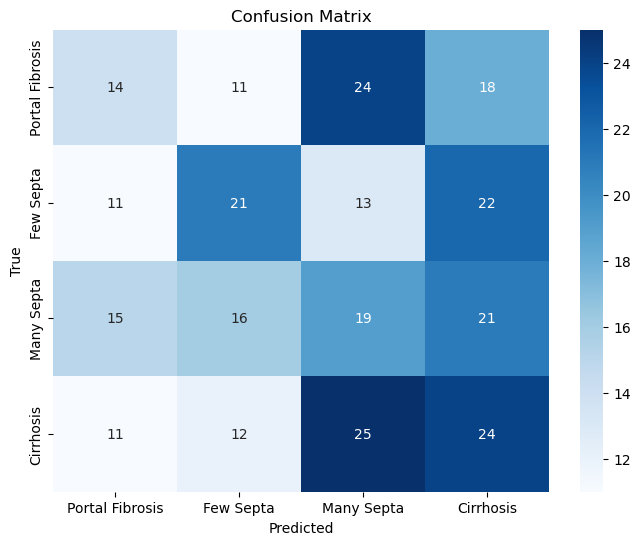

METRICS
Accuracy                 : 0.2816
Precision                : 0.2854
Recall                   : 0.2808
F1 Score                 : 0.2809


In [42]:
# Model Evaluation
evaluate_model(xgb_y_te, xgb_tuned_y_pred, [0, 1, 2, 3], ["Portal Fibrosis", "Few Septa", "Many Septa", "Cirrhosis"])

## KNN Classifier

### KNN Default

In [26]:
# KNN Model
knn_model = KNeighborsClassifier()
knn_model.fit(x_tr, y_tr.values.ravel())
knn_y_pred = knn_model.predict(x_te)

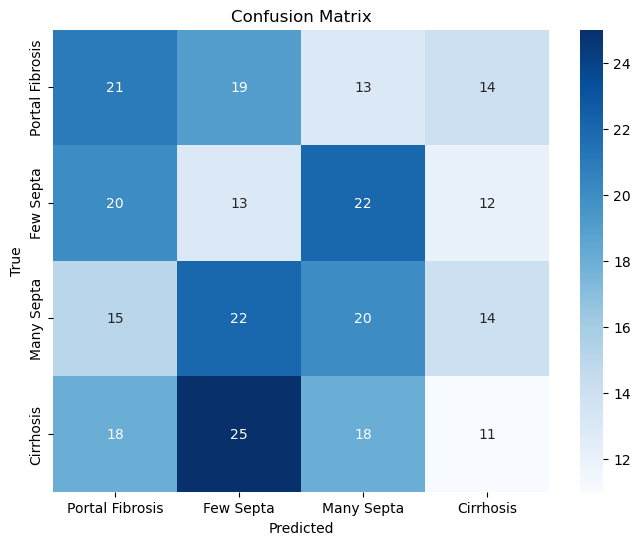

METRICS
Accuracy                 : 0.2347
Precision                : 0.2345
Recall                   : 0.2355
F1 Score                 : 0.2331


In [27]:
# Model Evaluation
evaluate_model(y_te, knn_y_pred, [1, 2, 3, 4], ["Portal Fibrosis", "Few Septa", "Many Septa", "Cirrhosis"])

### KNN Tuned

In [44]:
# Use Bayesian Optimization to find the best set of hyperparameters
knn_params = {"n_neighbors": (1, 20), 
              "weights": ["uniform", "distance"], 
              "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
              "leaf_size": (10, 50)}

knn_opt = BayesSearchCV(KNeighborsClassifier(), knn_params, verbose=3, n_iter=50)
knn_opt.fit(x_tr, y_tr.values.ravel())

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END algorithm=kd_tree, leaf_size=26, n_neighbors=4, weights=distance;, score=0.284 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=26, n_neighbors=4, weights=distance;, score=0.266 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=26, n_neighbors=4, weights=distance;, score=0.225 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=26, n_neighbors=4, weights=distance;, score=0.267 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=26, n_neighbors=4, weights=distance;, score=0.258 total time=   0.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END algorithm=ball_tree, leaf_size=40, n_neighbors=16, weights=uniform;, score=0.266 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=40, n_neighbors=16, weights=uniform;, score=0.248 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=40, n_neighbors=16, weights=uniform;, score=0.203 total t

BayesSearchCV(estimator=KNeighborsClassifier(),
              search_spaces={'algorithm': ['auto', 'ball_tree', 'kd_tree',
                                           'brute'],
                             'leaf_size': (10, 50), 'n_neighbors': (1, 20),
                             'weights': ['uniform', 'distance']},
              verbose=3)

In [45]:
# KNN Model
print(knn_opt.best_estimator_)
knn_model_tuned = knn_opt.best_estimator_
knn_tuned_y_pred = knn_model_tuned.predict(x_te)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=26, n_neighbors=4,
                     weights='distance')


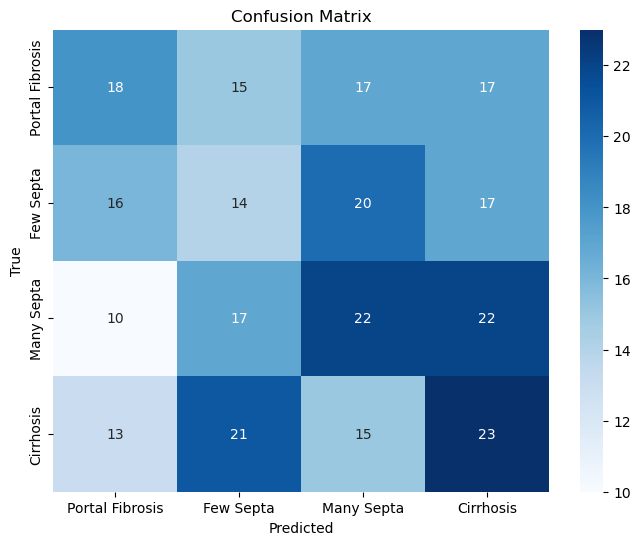

METRICS
Accuracy                 : 0.2780
Precision                : 0.2783
Recall                   : 0.2767
F1 Score                 : 0.2768


In [46]:
# Model Evaluation
evaluate_model(y_te, knn_tuned_y_pred, [1, 2, 3, 4], ["Portal Fibrosis", "Few Septa", "Many Septa", "Cirrhosis"])

## Multi-Layer Perceptron (MLP)

### MLP Default

In [28]:
# Simple MLP Model
mlp_model = MLPClassifier()
mlp_model.fit(x_tr, y_tr.values.ravel())
mlp_y_pred = mlp_model.predict(x_te)

C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


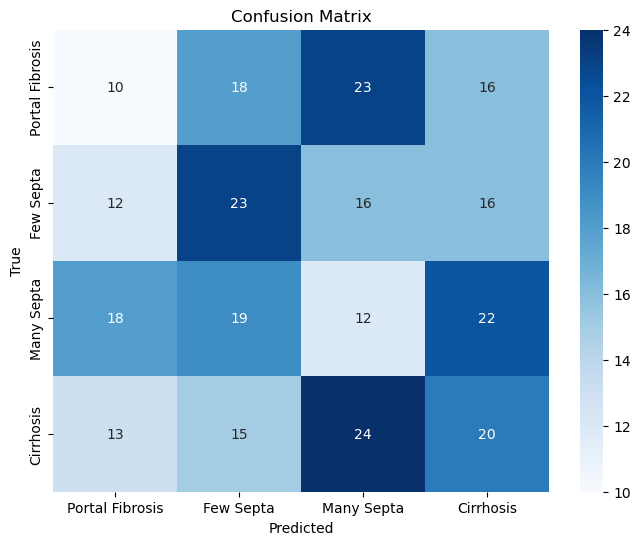

METRICS
Accuracy                 : 0.2347
Precision                : 0.2314
Recall                   : 0.2348
F1 Score                 : 0.2322


In [29]:
# Model Evaluation
evaluate_model(y_te, mlp_y_pred, [1, 2, 3, 4], ["Portal Fibrosis", "Few Septa", "Many Septa", "Cirrhosis"])

### MLP Tuned

In [53]:
# Use Bayesian Optimization to find the best set of hyperparameters
mlp_params = {"max_iter": (10, 5000), 
              "alpha": (0.000001, 0.01), 
              "learning_rate_init": (0.00001, 0.1)}

mlp_opt = BayesSearchCV(MLPClassifier(random_state=22), mlp_params, verbose=3, n_iter=50)
mlp_opt.fit(x_tr, y_tr.values.ravel())

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END alpha=0.003677230147069311, learning_rate_init=0.05233461737848214, max_iter=1255;, score=0.252 total time=   0.4s
[CV 2/5] END alpha=0.003677230147069311, learning_rate_init=0.05233461737848214, max_iter=1255;, score=0.252 total time=   0.6s
[CV 3/5] END alpha=0.003677230147069311, learning_rate_init=0.05233461737848214, max_iter=1255;, score=0.261 total time=   0.0s
[CV 4/5] END alpha=0.003677230147069311, learning_rate_init=0.05233461737848214, max_iter=1255;, score=0.240 total time=   0.5s
[CV 5/5] END alpha=0.003677230147069311, learning_rate_init=0.05233461737848214, max_iter=1255;, score=0.258 total time=   0.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END alpha=0.0014922263241816383, learning_rate_init=0.0541980529547203, max_iter=1566;, score=0.261 total time=   0.6s
[CV 2/5] END alpha=0.0014922263241816383, learning_rate_init=0.0541980529547203, max_iter=1566;, score=0.297 total

C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END alpha=0.0006802298295662343, learning_rate_init=1e-05, max_iter=10;, score=0.284 total time=   0.0s
[CV 4/5] END alpha=0.0006802298295662343, learning_rate_init=1e-05, max_iter=10;, score=0.285 total time=   0.0s
[CV 5/5] END alpha=0.0006802298295662343, learning_rate_init=1e-05, max_iter=10;, score=0.240 total time=   0.0s


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END alpha=0.0024383033013878493, learning_rate_init=0.00023169218319142698, max_iter=4979;, score=0.212 total time=  37.5s
[CV 2/5] END alpha=0.0024383033013878493, learning_rate_init=0.00023169218319142698, max_iter=4979;, score=0.270 total time=  47.3s
[CV 3/5] END alpha=0.0024383033013878493, learning_rate_init=0.00023169218319142698, max_iter=4979;, score=0.275 total time=  42.8s
[CV 4/5] END alpha=0.0024383033013878493, learning_rate_init=0.00023169218319142698, max_iter=4979;, score=0.249 total time=  48.1s
[CV 5/5] END alpha=0.0024383033013878493, learning_rate_init=0.00023169218319142698, max_iter=4979;, score=0.262 total time=  40.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END alpha=0.009998405642328451, learning_rate_init=0.09781298542874453, max_iter=4806;, score=0.270 total time=   0.9s
[CV 2/5] END alpha=0.009998405642328451, learning_rate_init=0.09781298542874453, max_iter=4806

C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1563) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END alpha=0.007061867300700032, learning_rate_init=0.0007457308150375213, max_iter=1563;, score=0.252 total time=  12.2s


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1563) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END alpha=0.007061867300700032, learning_rate_init=0.0007457308150375213, max_iter=1563;, score=0.284 total time=  13.9s


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1563) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END alpha=0.007061867300700032, learning_rate_init=0.0007457308150375213, max_iter=1563;, score=0.230 total time=  11.9s


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1563) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END alpha=0.007061867300700032, learning_rate_init=0.0007457308150375213, max_iter=1563;, score=0.271 total time=  13.0s


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1563) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END alpha=0.007061867300700032, learning_rate_init=0.0007457308150375213, max_iter=1563;, score=0.240 total time=  12.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END alpha=8.908775484800376e-05, learning_rate_init=0.011460494777732859, max_iter=4664;, score=0.270 total time=   3.4s
[CV 2/5] END alpha=8.908775484800376e-05, learning_rate_init=0.011460494777732859, max_iter=4664;, score=0.239 total time=   3.4s
[CV 3/5] END alpha=8.908775484800376e-05, learning_rate_init=0.011460494777732859, max_iter=4664;, score=0.234 total time=   4.1s
[CV 4/5] END alpha=8.908775484800376e-05, learning_rate_init=0.011460494777732859, max_iter=4664;, score=0.262 total time=   3.3s
[CV 5/5] END alpha=8.908775484800376e-05, learning_rate_init=0.011460494777732859, max_iter=4664;, score=0.213 total time=   3.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END alpha=0.0011141314370427902, learning_rate_init=0.055906869897877125, max_iter=2012;, sco

C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (132) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END alpha=1e-06, learning_rate_init=1e-05, max_iter=132;, score=0.248 total time=   1.0s


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (132) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END alpha=1e-06, learning_rate_init=1e-05, max_iter=132;, score=0.279 total time=   1.0s
[CV 3/5] END alpha=1e-06, learning_rate_init=1e-05, max_iter=132;, score=0.297 total time=   0.8s


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (132) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END alpha=1e-06, learning_rate_init=1e-05, max_iter=132;, score=0.285 total time=   1.1s
[CV 5/5] END alpha=1e-06, learning_rate_init=1e-05, max_iter=132;, score=0.267 total time=   0.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END alpha=0.009942865254301696, learning_rate_init=0.041534254885324716, max_iter=3133;, score=0.279 total time=   0.5s
[CV 2/5] END alpha=0.009942865254301696, learning_rate_init=0.041534254885324716, max_iter=3133;, score=0.297 total time=   0.5s
[CV 3/5] END alpha=0.009942865254301696, learning_rate_init=0.041534254885324716, max_iter=3133;, score=0.284 total time=   0.5s
[CV 4/5] END alpha=0.009942865254301696, learning_rate_init=0.041534254885324716, max_iter=3133;, score=0.222 total time=   0.4s
[CV 5/5] END alpha=0.009942865254301696, learning_rate_init=0.041534254885324716, max_iter=3133;, score=0.258 total time=   0.6s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END alpha=4.592459306578263e-05,

BayesSearchCV(estimator=MLPClassifier(random_state=22),
              search_spaces={'alpha': (1e-06, 0.01),
                             'learning_rate_init': (1e-05, 0.1),
                             'max_iter': (10, 5000)},
              verbose=3)

In [54]:
# MLP Model
print(mlp_opt.best_estimator_)
mlp_model_tuned = mlp_opt.best_estimator_
mlp_tuned_y_pred = mlp_model_tuned.predict(x_te)

MLPClassifier(alpha=0.001174479111702541, learning_rate_init=1e-05,
              max_iter=3844, random_state=22)


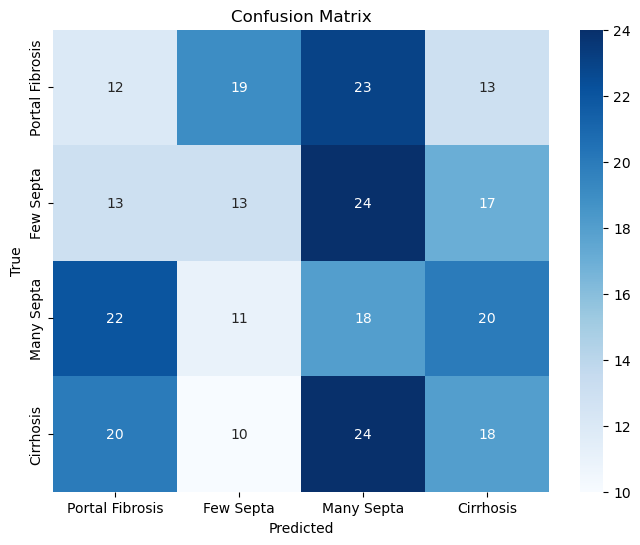

METRICS
Accuracy                 : 0.2202
Precision                : 0.2228
Recall                   : 0.2192
F1 Score                 : 0.2195


In [55]:
# Model Evaluation
evaluate_model(y_te, mlp_tuned_y_pred, [1, 2, 3, 4], ["Portal Fibrosis", "Few Septa", "Many Septa", "Cirrhosis"])

## Model Comparison

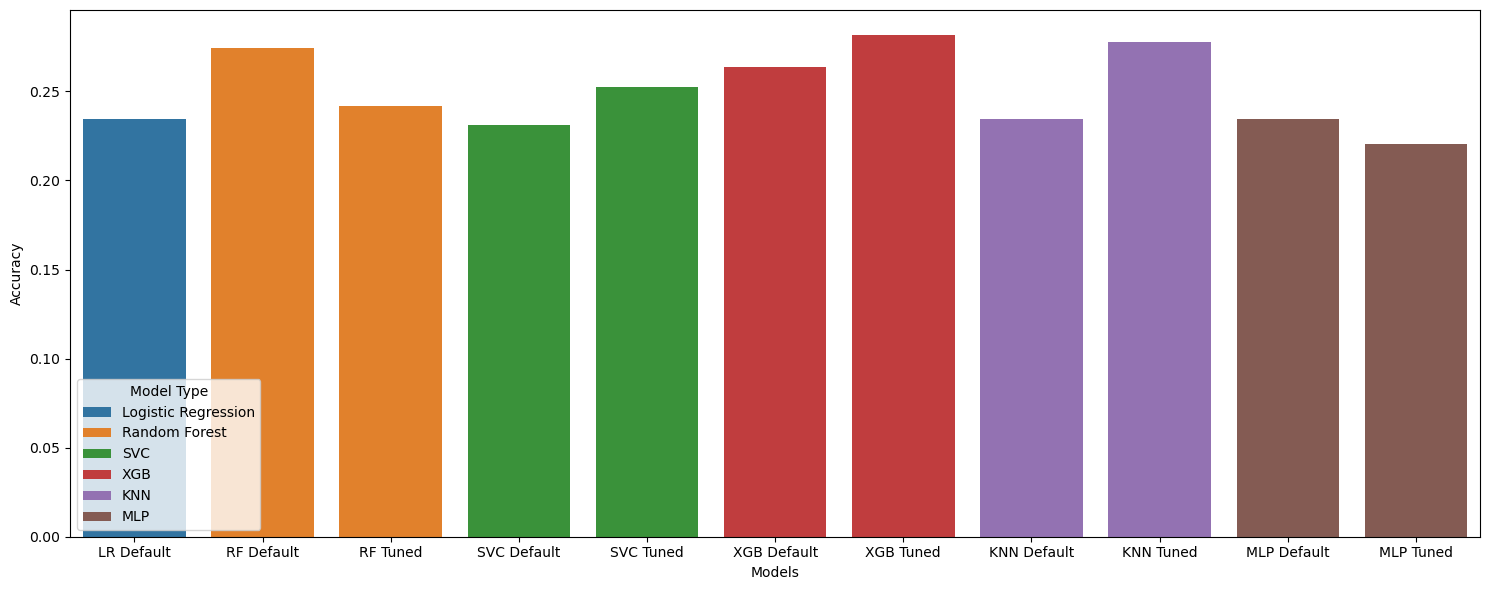

In [58]:
models = ["LR Default",  
          "RF Default", 
          "RF Tuned", 
          "SVC Default", 
          "SVC Tuned", 
          "XGB Default", 
          "XGB Tuned", 
          "KNN Default", 
          "KNN Tuned", 
          "MLP Default", 
          "MLP Tuned"]

accuracies = [accuracy_score(y_te, lr_y_pred), 
          accuracy_score(y_te, rf_y_pred), 
          accuracy_score(y_te, rf_tuned_y_pred), 
          accuracy_score(y_te, svc_y_pred), 
          accuracy_score(y_te, svc_tuned_y_pred), 
          accuracy_score(xgb_y_te, xgb_y_pred), 
          accuracy_score(xgb_y_te, xgb_tuned_y_pred),
          accuracy_score(y_te, knn_y_pred), 
          accuracy_score(y_te, knn_tuned_y_pred),
          accuracy_score(y_te, mlp_y_pred), 
          accuracy_score(y_te, mlp_tuned_y_pred)]

model_type = ["Logistic Regression", 
              "Random Forest", "Random Forest", 
              "SVC", "SVC", 
              "XGB", "XGB", 
              "KNN", "KNN", 
              "MLP", "MLP"]

comparison_data = pd.DataFrame({"Model Type": model_type, "Accuracy": accuracies, "Models": models})

fig, ax = plt.subplots(figsize=(15, 6))

sns.barplot(x="Models", y="Accuracy", data=comparison_data, hue="Model Type", ax=ax)
sns.move_legend(ax, "lower left")
plt.tight_layout()
plt.show()

## Discussion

The dataset appears to be notoriously difficult to predict as all classical models attempted including XGB can only achieve below 30% accuracy. Basic deep learning models like MLP also have similar accuracy scores. This is likely due to the nature of the issue being a multi-class classification issue which makes the differentiation for the models much more difficult. It could also be the nature of the issue itself, with stages of Hepatitis C on the liver being hard to differentiate. The best model so far is XGB tuned with an accuracy of 28%. This is still unusable for actual prediction and in the future more data and/or more advanced data pre-processing will be required to improve accuracy.

## References

1. Scikit Learn: KNN Classifier Documentation
2. Scikit Learn: MLP Classifier Documentation
3. Research Paper: Assisting the Non-invasive Diagnosis of Liver Fibrosis Stages using Machine Learning Methods

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

https://ieeexplore.ieee.org/document/9176542